# Assignment of Crowdsourced dataset of EEG Signals

This notebook provides a Python code for eye state classification using the RandomForest algorithm. Overall, I start by exploring data, for instance, drawing a trial for the open and closed eye and checking if the dataset is balanced. Then, the data is clean; for the signal, we could apply the band-pass filter. For feature extraction, I cumulatively worked on the model, which means I began with the baseline with limited features, and I also applied different methods of feature selection. until I achieved an acceptable accuracy.

- I use MNE-Python for standard EEG processing; for more details, see:
https://mne.tools/stable/index.html

- The dataset is available here: 
https://drive.google.com/drive/folders/1KQyST6VJffWWD8r60AjscBy6MHLnT184

- For more information about the dataset, see:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10404957/



### 1- Load dataset


In [4]:
import numpy as np
import pandas as pd

# Extract the data and labels
Data_npy = np.load("data/Crowdsource.npy", allow_pickle=True)
Data = {
    'train_data': Data_npy.item().get('train_data'),
    'train_label': Data_npy.item().get('train_label'), 
    'val_data': Data_npy.item().get('val_data'),
    'val_label': Data_npy.item().get('val_label'),
    'test_data': Data_npy.item().get('test_data'),
    'test_label': Data_npy.item().get('test_label')
}

In [5]:
# Print shapes of the data and labels to verify
Data["train_data"].shape , Data["train_label"].shape

((9456, 14, 256), (9456,))

### 2- Exploring and visualizing dataset (EEG Signals)

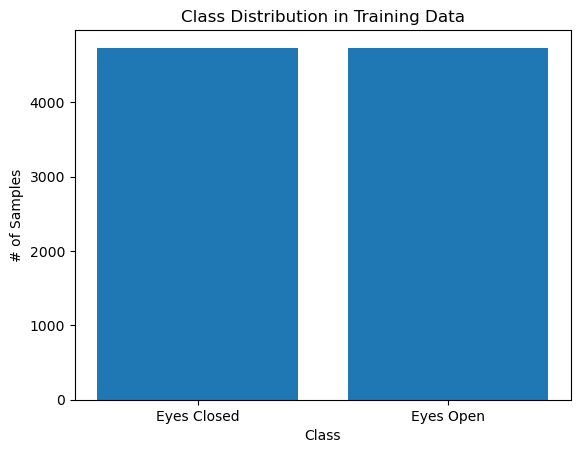

In [7]:
# Check if the dataset's classes are balance or note
import matplotlib.pyplot as plt
import numpy as np

# Get the counts for each class( close or open eyes
class_counts = np.bincount(Data['train_label'])

# Create the bar plot
plt.bar([0, 1], class_counts)  # Remove 'labels' from here
plt.xlabel('Class')
plt.ylabel('# of trials')
plt.title('Class Distribution in Training Data')
plt.xticks([0, 1], ['Eyes Closed', 'Eyes Open'])  # Set x-axis tick labels here
plt.show()

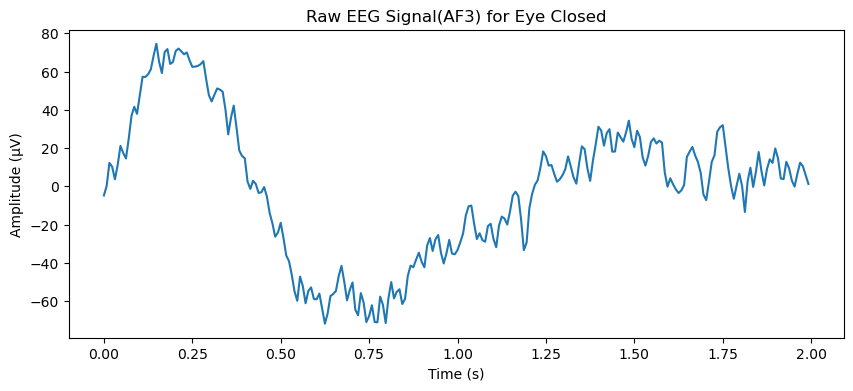

In [8]:
# Draw the First trial
import matplotlib.pyplot as plt
sample_trial = Data['train_data'][0] 
fs = 128  # sampling rate, originally 256 downsampled to 128 Hz
time = np.arange(len(sample_trial[0])) / fs

plt.figure(figsize=(10, 4))
plt.plot(time, sample_trial[0])  # First channel
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title('Raw EEG Signal(AF3) for '+('Eye Closed' if Data['train_label'][0]== 0  else 'Eye Open')  )
plt.show()


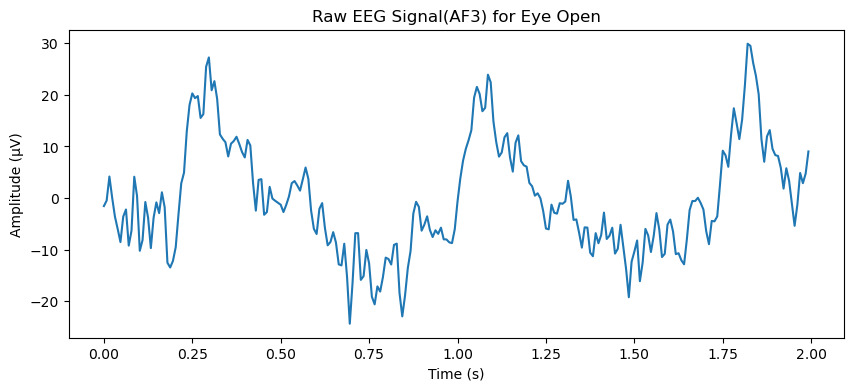

In [9]:
# Draw the second trial
import matplotlib.pyplot as plt
sample_trial = Data['train_data'][1] 
fs = 128  # sampling rate, originally 256 downsampled to 128 Hz
time = np.arange(len(sample_trial[1])) / fs

plt.figure(figsize=(10, 4))
plt.plot(time, sample_trial[1])  # First channel
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.title('Raw EEG Signal(AF3) for '+('Eye Closed' if Data['train_label'][1]== 0  else 'Eye Open')  )
plt.show()

In [10]:
# pip install mne

14
Creating RawArray with float64 data, n_channels=14, n_times=256
    Range : 0 ... 255 =      0.000 ...     1.992 secs
Ready.
Using matplotlib as 2D backend.


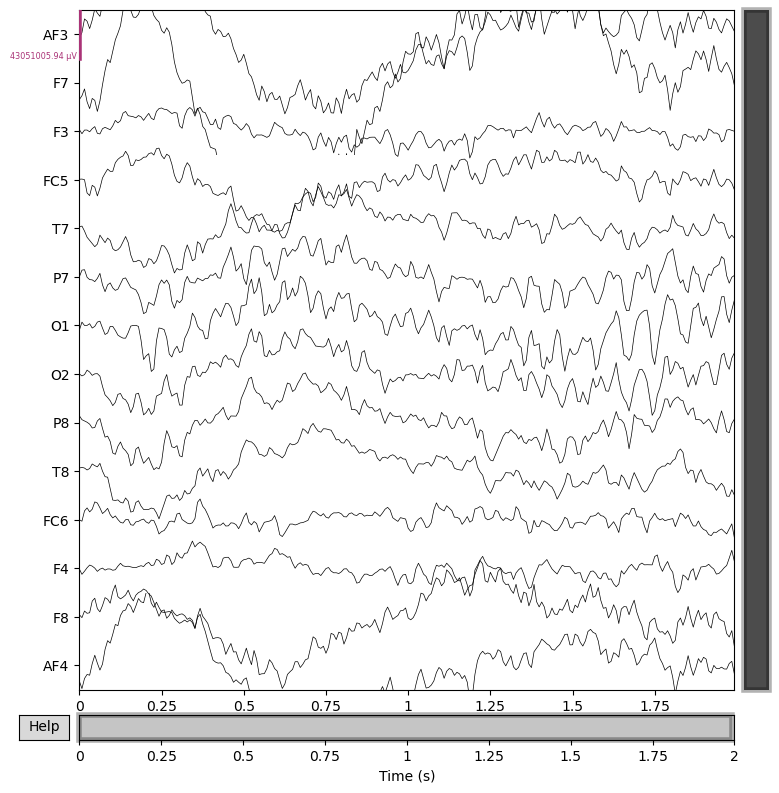

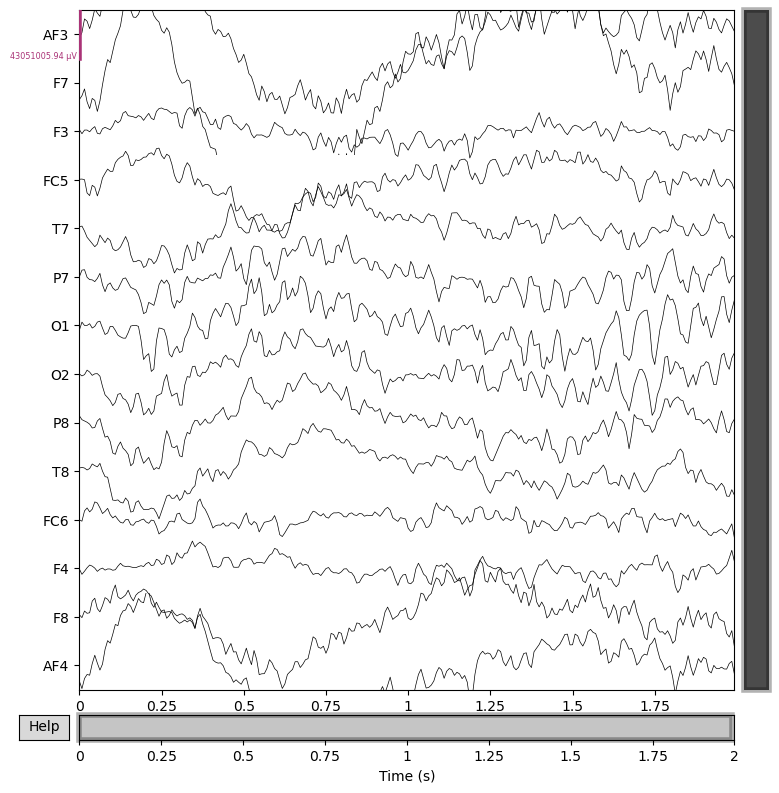

In [11]:
# Use MNE to facilitate Preprocessing and Feature Extraction of EEG signal
import mne

n_channels = Data['train_data'].shape[1]
print(n_channels)
fs = 128  # Sampling frequency
# Create channel names based on EMOTIV 14-channel configuration
ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 
            'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
# Create the info object to convert numpy array to MNE Raw object
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=['eeg'] * n_channels)

#-----------------------------------------------
# Plot one trial for all 14 channels
sample_trial = Data['train_data'][0]  # First trial
raw = mne.io.RawArray(sample_trial, info)
raw.plot(n_channels=14, scalings='auto', title='Raw EEG Signal for'+ ('Eye Closed' if Data['train_label'][0]== 0  else 'Eye Open'), show=True)


In [12]:
# Create EpochsArray for all trials
epochs_train = mne.EpochsArray(Data['train_data'], info=info)
epochs_val = mne.EpochsArray(Data['val_data'], info=info)
epochs_test = mne.EpochsArray(Data['test_data'], info=info)

# Load labels 
y_train = Data['train_label']  #np.array(Data['train_label'])
y_val = Data['val_label']
y_test = Data['test_label']

Not setting metadata
9456 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
947 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1893 matching events found
No baseline correction applied
0 projection items activated


### 3- Pre-processing data

In [14]:
%%capture
# Apply bandpass filter (0.5-40 Hz)
epochs_train = epochs_train.filter(l_freq=0.5, h_freq=40,
                                   method='fir', fir_design='firwin')
epochs_val = epochs_val.filter(l_freq=0.5, h_freq=40,
                                   method='fir', fir_design='firwin')
epochs_test =epochs_test.filter(l_freq=0.5, h_freq=40,
                                   method='fir', fir_design='firwin')


In [15]:
# I will not apply a notch filter since I am not sure about the power line frequency where the experiment was conducted.
# Notch Filter used to remove power line noise and its harmonics based on local power line frequency 
# epochs_train = epochs_train.notch_filter(freqs=??)

### 4- Feature extraction
There is a variety of features that can be extracted from the signal, such as:

Time-domain features capture signal characteristics in the time domain:
- mean: Average amplitude of the signal
- std: Standard deviation, representing signal dispersion
- variance: Variability of the signal
- ptp_amp: Peak-to-peak amplitude (max-min)
- zero_crossings: Number of times the signal crosses zero

Frequency-domain features analyse the power of signals in different frequency bands:
- pow_freq_bands: Power of predefined EEG frequency bands
- spect_entropy: Measures the spectral entropy of the signal, which represents the distribution of power across different frequencies. 
- spect_edge_freq: Computes the spectral edge frequency, which is the frequency below which a certain percentage of the total power is contained (typically 90%). It is useful for analyzing the dominant frequency range of EEG signals.

Hjorth parameters describe the complexity and mobility of signals:
- hjorth_mobility: Ratio of the standard deviation of the first derivative to the signal
- hjorth_complexity: How the mobility changes over time (higher means more complex signal)

Entropy-based features measure the randomness of the signal:
- app_entropy: Approximate entropy, capturing unpredictability in EEG signals

In [17]:
# pip install mne_features -q

In [18]:
# In this code I used the MNE built-in Functions to extract various features from epoched EEG data.
# For more details about the features (Univariate or Bivariate) that can be extracted  see:https://mne.tools/mne-features/api.html
import mne_features
from mne_features.feature_extraction import extract_features

# Define the features to extract, here I try to adjust this set until I get an acceptable result.
time_domain_features = ['mean', 'std', 'variance', 'ptp_amp', 'zero_crossings']
frequency_domain_features = [ 'spect_entropy', 'spect_edge_freq'] #'pow_freq_bands', shows me an error message therefore I add the code in the next cell
hjorth_parameters = ['hjorth_mobility', 'hjorth_complexity']
entropy_features = ['app_entropy'] 

selected_features= time_domain_features + frequency_domain_features + hjorth_parameters + entropy_features
# Extract features using mne_features                                             
X_train_features = extract_features(epochs_train.get_data(),
                                                 sfreq=128,
                                                 selected_funcs=selected_features)

X_val_features = extract_features(epochs_val.get_data(),
                                                  sfreq=128,
                                                 selected_funcs=selected_features)
                                               
                                               
X_test_features = extract_features(epochs_test.get_data(),
                                                sfreq=128,
                                                selected_funcs=selected_features)                                          

In [19]:
# Print shapes to verify => 10 features * 14 channels = 140
print(X_train_features.shape)
print(X_val_features.shape)
print(X_test_features.shape)

(9456, 140)
(947, 140)
(1893, 140)


In [20]:
# Calculation of Power Spectral Density (PSD) using Welch's method  within defined frequency bands (Delta, Theta, Alpha, Beta, and Gamma). 
# Define valid frequency bands (≤ Nyquist frequency)
sfreq = 128
nyquist = sfreq / 2  # 64 Hz
freq_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 63)
}

#---------------------------------------------------------
# Compute PSD using Welch method and extracts power in predefined frequency bands.
def compute_psd_bands(epochs):  
    psd = epochs.compute_psd(method="welch", fmin=0.5, fmax=40, verbose=False)
    freqs = psd.freqs  # Extract frequency bins
    psd_data = psd.get_data()

    # Initialize an array to store power in each band
    psd_band = np.zeros((psd_data.shape[0], psd_data.shape[1], len(freq_bands)))

    for i, (band, (fmin, fmax)) in enumerate(freq_bands.items()):
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        psd_band[:, :, i] = np.sum(psd_data[:, :, band_mask], axis=-1)

    return psd_band  #  Returns array of shape (samples, channels, bands)

#---------------------------------------------------------
# Compute PSD band features for all data
psd_band_train = compute_psd_bands(epochs_train)
psd_band_val = compute_psd_bands(epochs_val)
psd_band_test = compute_psd_bands(epochs_test)

# Print shapes to verify (trails, channels, bands)
print( psd_band_train.shape)
print( psd_band_val.shape)
print( psd_band_test.shape)

# EEG PSD data is often in 3D (trails, channels, bands), so it needs to be flattened into 2D  (trails × features).
X_train_psd = psd_band_train.reshape(psd_band_train.shape[0], -1) # [0] Keeps the number of epochs the same (first dimension), -1 flattens the remaining dimensions into one.
X_val_psd = psd_band_val.reshape(psd_band_val.shape[0], -1)
X_test_psd = psd_band_test.reshape(psd_band_test.shape[0], -1)

# Print shapes to verify
print (X_train_psd.shape)
print (X_val_psd.shape)
print (X_test_psd.shape)

# Concatenate PSD features with other features
X_train = np.concatenate([X_train_features, X_train_psd], axis=1)
X_val = np.concatenate([X_val_features, X_val_psd], axis=1)
X_test = np.concatenate([X_test_features, X_test_psd], axis=1)


(9456, 14, 5)
(947, 14, 5)
(1893, 14, 5)
(9456, 70)
(947, 70)
(1893, 70)


In [21]:
# Print shapes to verify => 140+70 =210 
print (X_train.shape)
print (X_val.shape)
print (X_test.shape)

(9456, 210)
(947, 210)
(1893, 210)


In [22]:
# Normalize features, 
#for EEG signals, the StandardScaler is considered suitable if it is used for instance  with PCA, MinMaxScaler (0-1 scaling) is suitable for neural networks.
from sklearn.preprocessing import StandardScaler is best expect if it uesd for deeplearing 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

##### 5- Feature selection\Dimensionality reduction
Three different feature selection methods are tested in the code:
- SelectKBest (ANOVA F-score)
- SelectKBest (Mutual Information)
- Variance Threshold (low-variance)
- LASSO (L1 Regularization) 

Dimensionality reduction technique:
- PCA (Principal Component Analysis) is a dimensionality reduction technique used to reduce the number of features while preserving the most important information in the data.PCA transforms the features into a new space where they are uncorrelated.

Note: Feature selection keeps the important original features and removes the less important ones. Dimensionality reduction, like PCA, makes new features (principal components) by combining existing features in a way that preserves the most variance in the data.

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV

# Method 1:  ANOVA F-score

sel_kbest = SelectKBest(score_func=f_classif, k=50) # 50,100
X_train_kbest = sel_kbest.fit_transform(X_train_scaled, y_train )
X_val_kbest = sel_kbest.transform(X_val_scaled )
X_test_kbest = sel_kbest.transform(X_test_scaled )

In [25]:
# Method 2:  mutual information

sel_kbest_mi = SelectKBest(score_func=mutual_info_classif, k=50)
X_train_kbest_mi = sel_kbest_mi.fit_transform(X_train_scaled, y_train )
X_val_kbest_mi= sel_kbest.transform(X_val_scaled )
X_test_kbest_mit=sel_kbest.transform(X_test_scaled )

In [26]:
# Method 3: Variance Threshold - Remove low-variance features

sel_var = VarianceThreshold(threshold=1)  # Remove features with variance below 1
X_train_vth = sel_var.fit_transform(X_train_scaled )
X_val_vth = sel_var.transform(X_val_scaled )
X_test_vth = sel_var.transform(X_test_scaled )

In [27]:
# Method 4: LASSO (L1 Regularization) for Feature Selection

lasso = LassoCV(cv=5, random_state=42, max_iter=10000)  # Increased iterations for better convergence
lasso.fit(X_train_scaled , y_train)
selected_features_lasso = np.where(np.abs(lasso.coef_) > 1e-2)[0]  # More aggressive feature elimination 
#selected_features_lasso = np.where(lasso.coef_ != 0)[0]  # Select non-zero coefficient features

# Apply LASSO-selected features
X_train_lasso = X_train_scaled[:, selected_features_lasso]
X_val_lasso = X_val_scaled [:, selected_features_lasso]
X_test_lasso = X_test_scaled [:, selected_features_lasso]

In [28]:
# Method 5:  Apply PCA for dimensionality reduction

sel_pca = PCA(n_components=50)  # Adjust the number of components as needed
X_train_pca = sel_pca.fit_transform(X_train_scaled )
X_val_pca = sel_pca.transform(X_val_scaled )
X_test_pca = sel_pca.transform(X_test_scaled )

In [189]:
# Print shapes to compare and verify 
print( X_train_scaled.shape)
print( X_train_kbest.shape)
print( X_train_kbest_mi.shape)
print( X_train_vth.shape )
print( X_train_lasso.shape )
print( X_train_pca.shape )

(9456, 210)
(9456, 50)
(9456, 50)
(9456, 111)
(9456, 145)
(9456, 50)


### 6- Training & validation

In [179]:
# Train and Compare Different Classifiers by defining different Random Forest models with varying hyperparameters.

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import clone  # Import clone

# Store results  for different RF models and feature selection methods
results_df = []
rf_feature_results = {}
rf_comparison_results = {}
# To save the model with the highest accuracy
best_model = None
best_accuracy = 0
best_rf = None
best_feature = None

# Different Random Forest model hyperparameter
random_forest_models = { 
    "RF Default": RandomForestClassifier(n_estimators=50, random_state=42),
    "RF More Trees": RandomForestClassifier(n_estimators=200, random_state=42),
    "RF Depth 10": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "RF Min Samples Split 5": RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=42),
    "RF Max Features sqrt": RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42), 

}

# Different feature selection methods
feature_sets = {
        "All_Features": (X_train_scaled, X_val_scaled), # No features was selected
        "ANOVA F-score":(X_train_kbest, X_val_kbest),   
        "Mutual Information":(X_train_kbest_mi, X_val_kbest_mi),
        "Variance Threshold":(X_train_vth, X_val_vth),
        "LASSO": (X_train_lasso, X_val_lasso),
        "PCA":(X_train_pca, X_val_pca),
}

# Train, evaluate and store results for different RF models and feature selection methods
# Iterate through feature sets & models 
for feature_name, (train_feat, val_feat) in feature_sets.items():
    for model_name, model_template in random_forest_models.items():
        rf = clone(model_template) # Clone the model to avoid overwriting
        rf.fit(train_feat, y_train)
        predictions = rf.predict(val_feat)
        accuracy = accuracy_score(y_val, predictions)
        # Store results
        rf_comparison_results[(feature_name, model_name)] = accuracy
        results_df.append([feature_name, model_name, accuracy])        
        print(f"Random Forest- {feature_name} & { model_name} => Accuracy: {accuracy:.3f}")                  
        # Update the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = feature_name
            best_model = model_name
            best_rf = rf
            

Random Forest- All_Features & RF Default => Accuracy: 0.749
Random Forest- All_Features & RF More Trees => Accuracy: 0.797
Random Forest- All_Features & RF Depth 10 => Accuracy: 0.808
Random Forest- All_Features & RF Min Samples Split 5 => Accuracy: 0.795
Random Forest- All_Features & RF Max Features sqrt => Accuracy: 0.785
Random Forest- ANOVA F-score & RF Default => Accuracy: 0.740
Random Forest- ANOVA F-score & RF More Trees => Accuracy: 0.762
Random Forest- ANOVA F-score & RF Depth 10 => Accuracy: 0.742
Random Forest- ANOVA F-score & RF Min Samples Split 5 => Accuracy: 0.759
Random Forest- ANOVA F-score & RF Max Features sqrt => Accuracy: 0.765
Random Forest- Mutual Information & RF Default => Accuracy: 0.624
Random Forest- Mutual Information & RF More Trees => Accuracy: 0.731
Random Forest- Mutual Information & RF Depth 10 => Accuracy: 0.705
Random Forest- Mutual Information & RF Min Samples Split 5 => Accuracy: 0.615
Random Forest- Mutual Information & RF Max Features sqrt => Acc

In [181]:
# To verify
print( "Best configuration: " ,  best_model, "-", best_feature  ,  f" Acu= {best_accuracy:.3f}"   )
print(" " , best_rf )

Best configuration:  RF Depth 10 - Variance Threshold  Acu= 0.819
  RandomForestClassifier(max_depth=10, random_state=42)


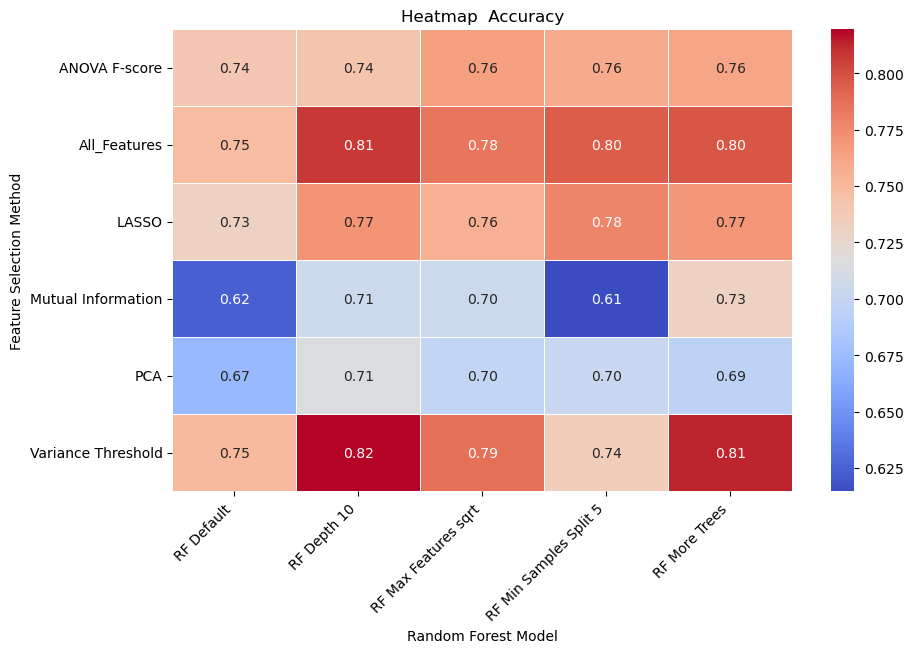

In [183]:
# Visualization using heatmap
import seaborn as sns
# Convert results to DataFrame 
R = pd.DataFrame(results_df, columns=['Feature Selection', 'Random Forest Model', 'Accuracy'])

plt.figure(figsize=(10, 6))
sns.heatmap(R.pivot(index='Feature Selection', columns='Random Forest Model', values='Accuracy'), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Heatmap  Accuracy")
plt.xlabel("Random Forest Model")
plt.ylabel("Feature Selection Method")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

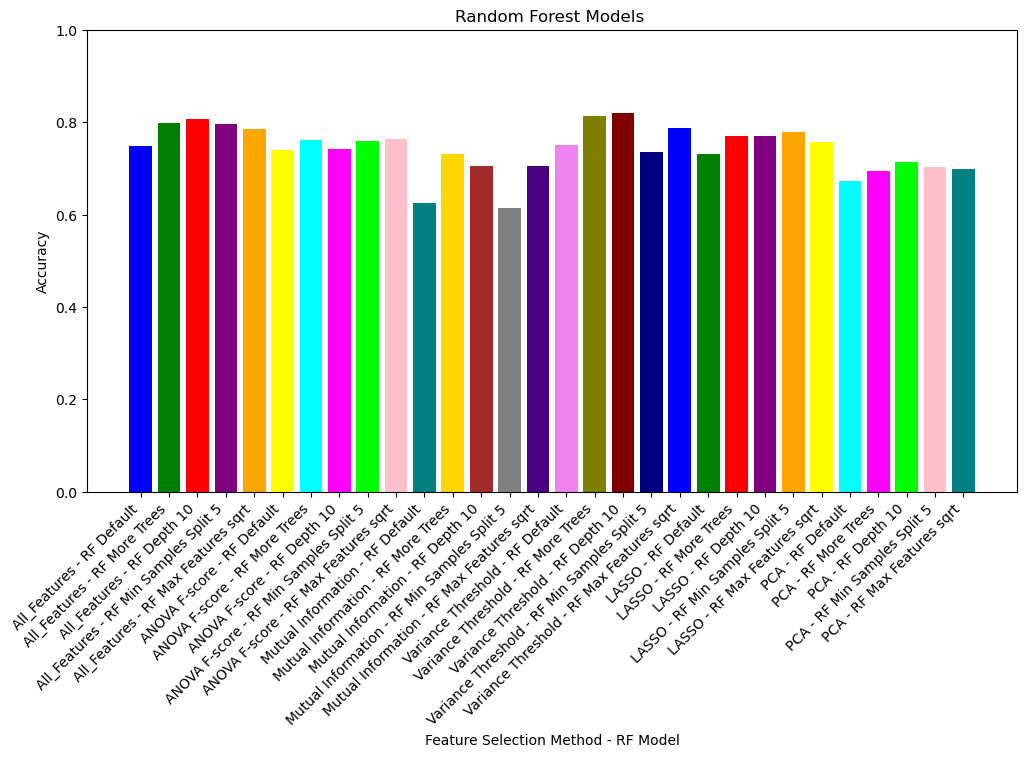

In [185]:
# Visualization using barchart
plt.figure(figsize=(12,6))
keys = list(rf_comparison_results.keys())
values = list(rf_comparison_results.values())
x_labels = [f"{feat} - {model}" for feat, model in keys]
plt.bar(x_labels, values, color=['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'cyan',
                                 'magenta', 'lime', 'pink', 'teal', 'gold', 'brown', 'gray', 'indigo', 'violet', 
                                 'olive', 'maroon', 'navy']*len(feature_sets))
plt.xlabel("Feature Selection Method - RF Model")
plt.ylabel("Accuracy")
plt.title("Random Forest Models ")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#|| Results of different configuration ||
# baseline 43%
# using psd only 66%
# using pow_freq_bands 67 %
# using pow_freq_bands + ptp_amp  68%
# using pow_freq_bands + ptp_amp + psd 69%
# using pow_freq_bands + ptp_amp + psd + zero_crossings 75%
# using pow_freq_bands + ptp_amp + psd + zero_crossings + mean 77%
# using pow_freq_bands + ptp_amp + psd + zero_crossings + mean + hyperparameter of RandomForest optimization 80%
#  varing  hyperparameter ....... etc

### 7- Evaluation

Best configuration is Variance Threshold - RF Depth 10
Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.90      0.82      0.85       947
           1       0.83      0.91      0.87       946

    accuracy                           0.86      1893
   macro avg       0.86      0.86      0.86      1893
weighted avg       0.86      0.86      0.86      1893



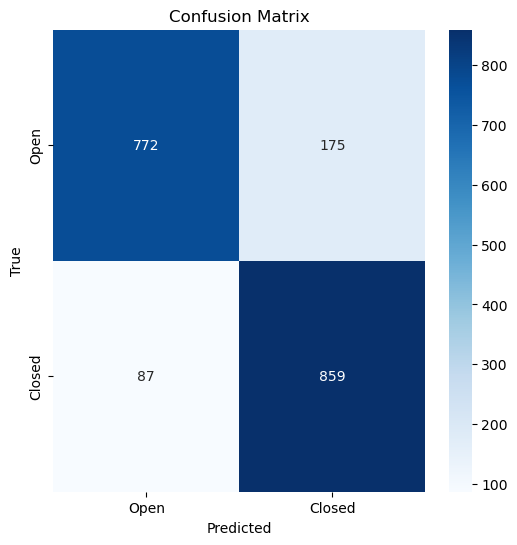

In [191]:
# Finally, test data is used to evaluate the nominated classifier 
from sklearn.metrics import accuracy_score, classification_report

print( "Best configuration is " + best_feature  ,"-"  , best_model)
#Here the Random_Forest_ is evaluated 
y_pred = best_rf.predict(X_test_vth )

accuracy_final = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_final:.2f}")
print(report)

# Confusion Matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Open', 'Closed'], 
            yticklabels=['Open', 'Closed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()

### -------------------------------------------------------------------
This is the end of a Jupyter notebook written by Hanan Al Tamimi.
### -------------------------------------------------------------------